**Loading the libraries and importing the packages**

In [49]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

import warnings
warnings.filterwarnings('ignore')

**Load Dataset**:
Sales records of 10 stores and 50 products, from the year 2013 through 2017.

In [50]:
df = pd.read_csv('/content/Sales_dataset.csv')
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


**Checking for missing values.**

In [51]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

****

**Data Preprocessing**: Here we consider only the sales of 'item' - 1 from 'store' - 1. The dataset has been divided into two sets: the training set containing sales records from January 2013 to September 2017, and the test set (validation set) containing sales records from the final three months of 2017.

In [52]:
# Filter records for store 1 and item 1 -> to be able to scale to other items in the future
df = df[df['store'] == 1]
df = df[df['item'] == 1]

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # convert date column to datatime object

# Create Date-related Features to be used for EDA and Supervised ML: Regression
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)

train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


In [53]:
test_df.head()

,date,store,item,sales,year,month,day,weekday
0,2017-10-01,1,1,21,2017,10,1,6
1,2017-10-02,1,1,12,2017,10,2,7
2,2017-10-03,1,1,18,2017,10,3,1
3,2017-10-04,1,1,15,2017,10,4,2
4,2017-10-05,1,1,20,2017,10,5,3


**Data Exploration**: Here we use various plots to analyse the distribution of sales through weeks, months and years. We will also see the variations in the sales of our considered product (Item-1 from Store-1) over the years.

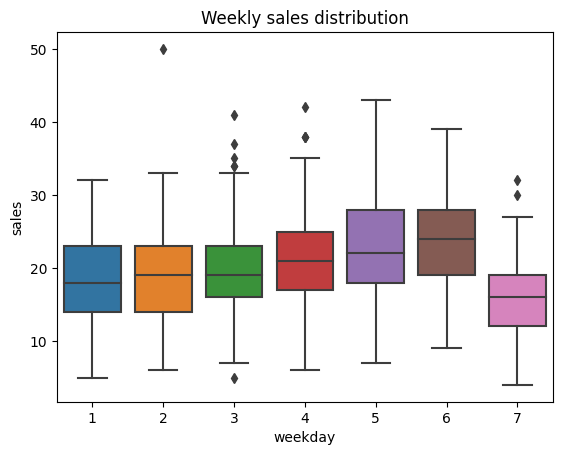

In [54]:
plot = sn.boxplot(x='weekday', y='sales', data=df)
_ = plot.set(title='Weekly sales distribution')

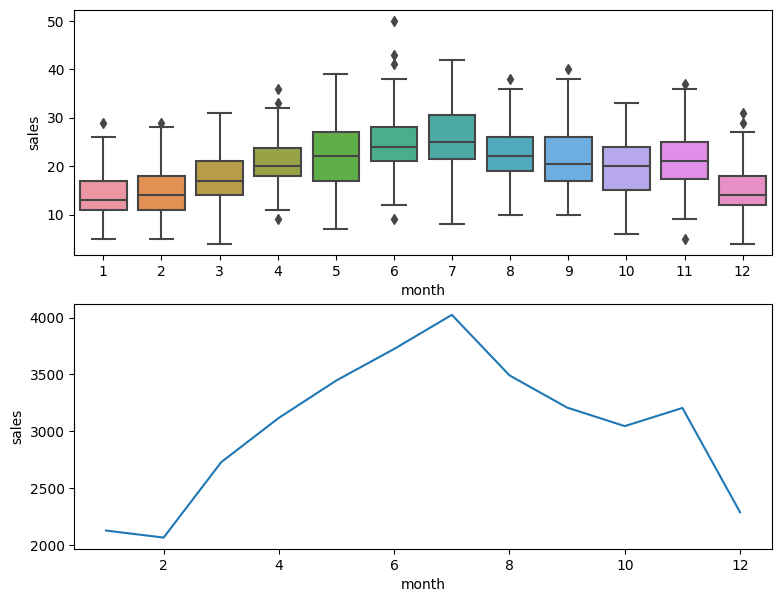

In [55]:
# Calculate monthly sales aggregation
monthly_agg = df.groupby('month')['sales'].sum().reset_index()

# Visualize sales distribution and trends per month
fig, axs = plt.subplots(nrows=2, figsize=(9, 7))
sn.boxplot(x='month', y='sales', data=df, ax=axs[0])
_ = sn.lineplot(x='month', y='sales', data=monthly_agg, ax=axs[1])



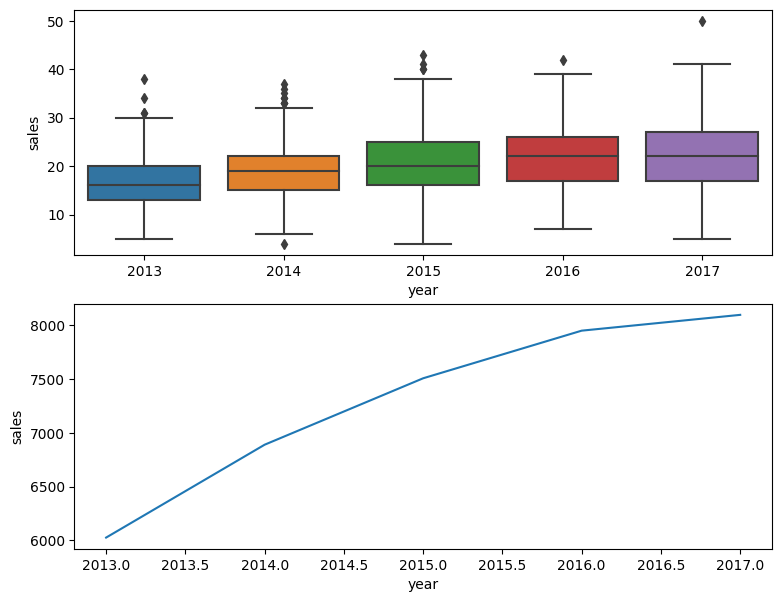

In [56]:
yearly_agg = df.groupby('year')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='sales', data=df, ax=axs[0])
_ = sn.lineplot(x='year', y='sales', data=yearly_agg, ax=axs[1])

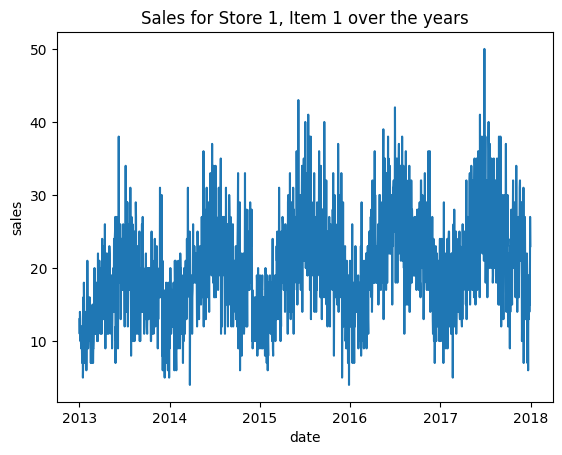

In [57]:
plot = sn.lineplot(x='date', y='sales', data=df)
_ = plot.set(title='Sales for Store 1, Item 1 over the years')

**Seasonal Naive Model**: Seasonal Naive Model bases its forecasts solely on the observation from the previous season or period that is it takes the seasonal patterns into account by looking at what happened same time last year. For example,  For instance, if forecasting sales for December 2017, the Seasonal Naive Method would predict a sales figure identical to that of December 2016.

In [58]:
# Calculate dates one year prior in the test data
dates = (test_df['date'] - np.timedelta64(1, 'Y') + np.timedelta64(1, 'D')).values.astype('datetime64[D]')
# Fetch sales data from the previous year's equivalent dates
seasonal_naive_sales = train_df[train_df['date'].astype('datetime64[D]').isin(dates)]['sales']

# Create a copy of test_df and predict using the Seasonal Naive Model for the last 3 months of 2017
sn_pred_df = test_df.copy().drop('sales', axis=1)
sn_pred_df['seasonal_naive_sales'] = pd.DataFrame(seasonal_naive_sales).set_index(test_df.index)
sn_pred_df.head()


,date,store,item,year,month,day,weekday,seasonal_naive_sales
0,2017-10-01,1,1,2017,10,1,6,25
1,2017-10-02,1,1,2017,10,2,7,26
2,2017-10-03,1,1,2017,10,3,1,20
3,2017-10-04,1,1,2017,10,4,2,28
4,2017-10-05,1,1,2017,10,5,3,17


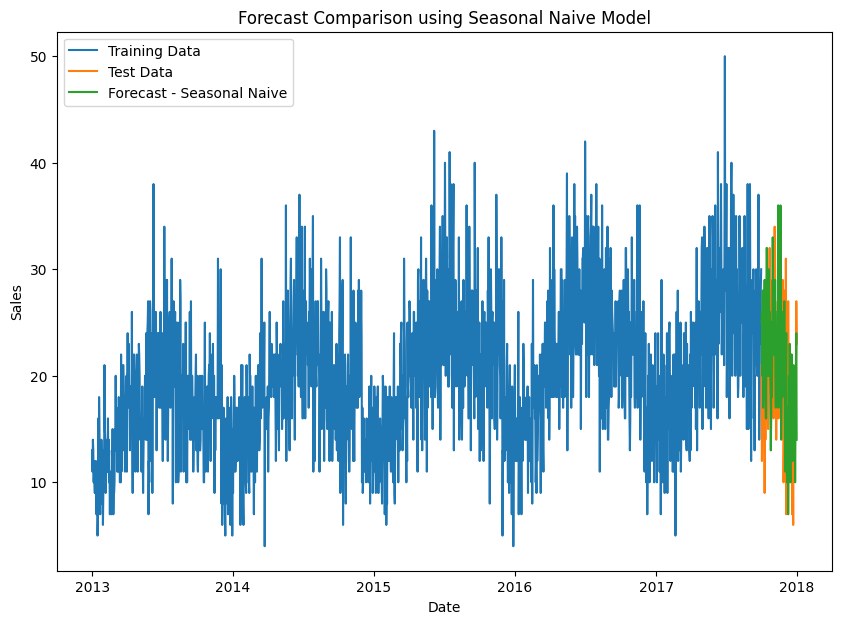

In [59]:
plt.figure(figsize=(10, 7))

# Plotting training, test, and Seasonal Naive Model forecast sales
plt.plot(train_df['date'], train_df['sales'], label='Training Data')
plt.plot(test_df['date'], test_df['sales'], label='Test Data')
plt.plot(sn_pred_df['date'], sn_pred_df['seasonal_naive_sales'], label='Forecast - Seasonal Naive')

# Adding labels and title
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Forecast Comparison using Seasonal Naive Model')
plt.show()


**Evaluating the Forecasts**: To evaluate the overall forecast, we'll consider some error metrics such as mean absolute error (MAE), root mean squared error (RMSE), and a percentage-based metric known as mean absolute percentage error (MAPE).

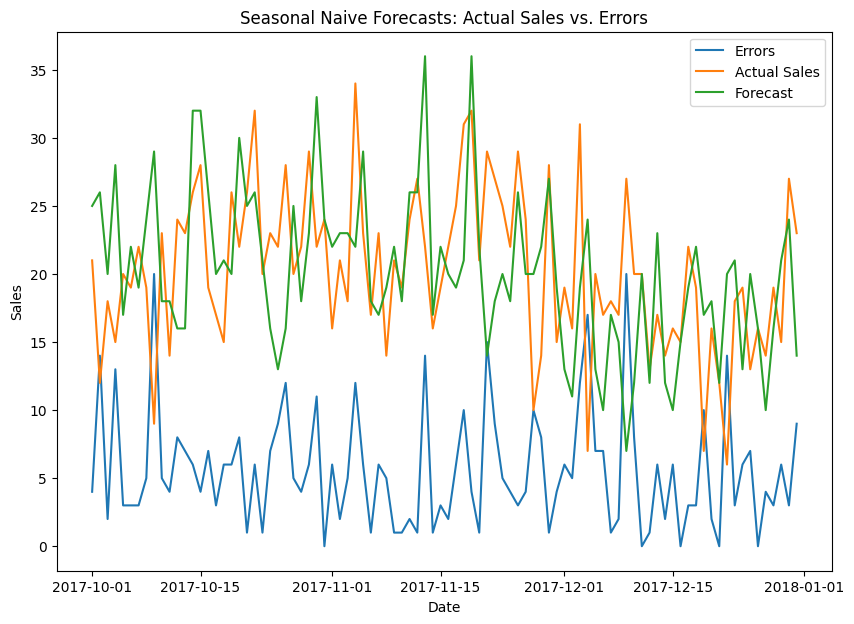

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive,1861,1857,4,5.630435,7.130766,27.834498


In [60]:
# Merging test data and Seasonal Naive Model predictions
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]

# Computing errors and adding 'model' column
errors_df['errors'] = errors_df['sales'] - errors_df['seasonal_naive_sales']
errors_df.insert(0, 'model', 'Seasonal Naive')

# Functions for error metrics
def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=errors_df['sales']):
    return np.sum(np.abs(err)) / np.sum(sales) * 100

# Aggregating error metrics by model
result_df = errors_df.groupby('model').agg(
    total_sales=('sales', 'sum'),
    total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
    overall_error=('errors', 'sum'),
    MAE=('errors', mae),
    RMSE=('errors', rmse),
    MAPE=('errors', mape)
)

# Plotting sales, forecast, and errors
plt.figure(figsize=(10, 7))
plt.plot(errors_df['date'], np.abs(errors_df['errors']), label='Errors')
plt.plot(errors_df['date'], errors_df['sales'], label='Actual Sales')
plt.plot(errors_df['date'], errors_df['seasonal_naive_sales'], label='Forecast')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Seasonal Naive Forecasts: Actual Sales vs. Errors')
plt.show()

result_df


**Linear Regression Model**: Linear regression is a supervised learning algorithm used for modeling the relationship between dependent variables and one or more independent variables. It assumes a linear relationship between input features and the target variable, aiming to minimize the difference between predicted and actual values by finding the best-fit line through the data. Here we will apply Linear Regression to our given sales data in order to forecasts sales.

In [61]:
reg_df = df
reg_df

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5
...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14,2017,12,27,2
1822,2017-12-28,1,1,19,2017,12,28,3
1823,2017-12-29,1,1,15,2017,12,29,4
1824,2017-12-30,1,1,27,2017,12,30,5


**Step-1**: Feature Engineering

In [62]:
# Lag features
for i in range(1,8):
    lag_i = 'lag_' + str(i)
    reg_df[lag_i] = reg_df.sales.shift(i)

# Rolling window
reg_df['rolling_mean'] = reg_df.sales.rolling(window=7).mean()
reg_df['rolling_max'] = reg_df.sales.rolling(window=7).max()
reg_df['rolling_min'] = reg_df.sales.rolling(window=7).min()

reg_df = reg_df.dropna(how='any', inplace=False)
reg_df = reg_df.drop(['store', 'item'], axis=1)

# Split the series to predict the last 3 months of 2017
reg_df = reg_df.set_index('date')
reg_train_df = reg_df.loc[:'2017-09-30']
reg_test_df = reg_df.loc['2017-10-01':]


**Step-2**: Feature Selection and Model Building

In [63]:
# Splitting the Data into Features and Target Variables
X_train = reg_train_df.drop(['sales'], axis=1)
y_train = reg_train_df['sales'].values

X_test = reg_test_df.drop(['sales'], axis=1)
y_test = reg_test_df['sales'].values

# Feature Selection: Using Univariate SelectKBest to Extract Top 5 Features
top_features = SelectKBest(score_func=f_regression, k=5)
fit = top_features.fit(X_train, y_train)

# Creating DataFrames to Store Feature Scores
feature_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': fit.scores_
})

# Sorting and Displaying the Top 5 Features with the Highest Scores
top_5_features = feature_scores.nlargest(5, 'Score')
print(top_5_features)


         Feature        Score
11  rolling_mean  1577.946956
12   rolling_max  1170.464035
13   rolling_min   888.451268
10         lag_7   860.565955
4          lag_1   449.743115


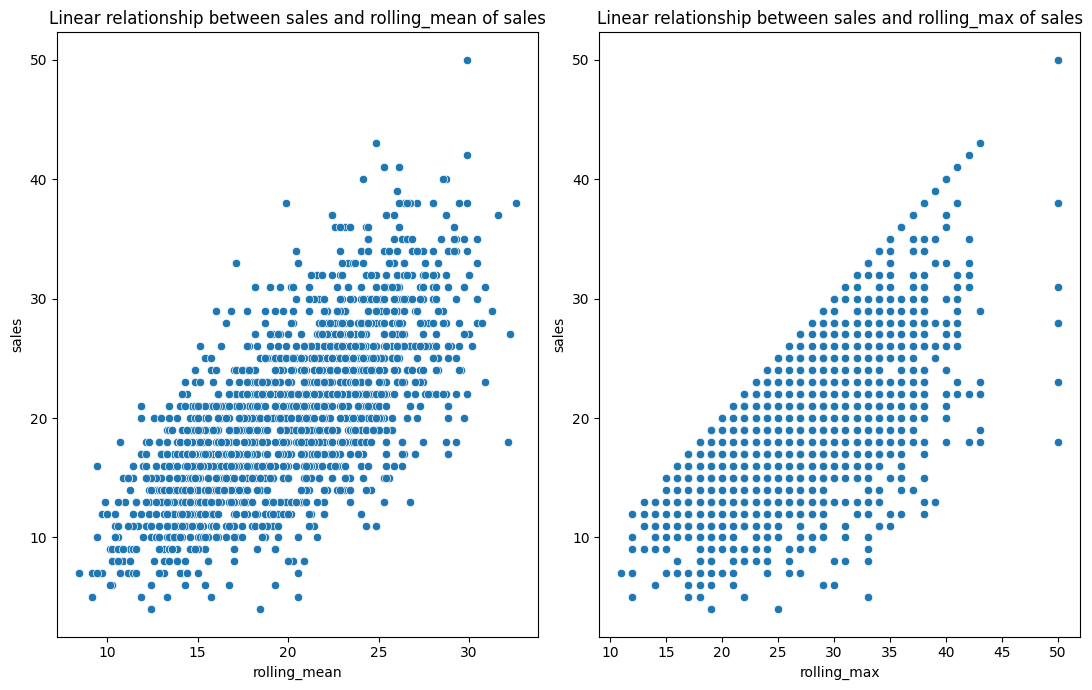

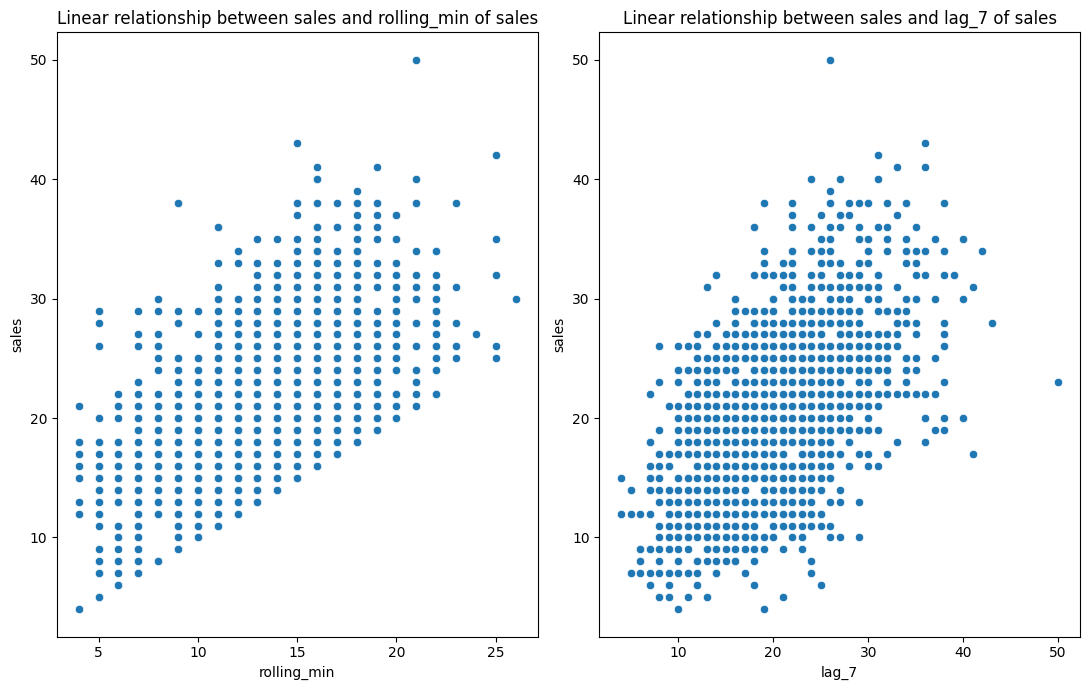

In [64]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(11, 7))

# First Row of Subplots: scatterplots for rolling_mean and rolling_max
sns.scatterplot(x='rolling_mean', y='sales', data=reg_train_df, ax=axs[0])
axs[0].set_title('Linear relationship between sales and rolling_mean of sales')

sns.scatterplot(x='rolling_max', y='sales', data=reg_train_df, ax=axs[1])
axs[1].set_title('Linear relationship between sales and rolling_max of sales')

plt.tight_layout()
plt.show()

# Second Row of Subplots: scatterplots for rolling_min and lag_7
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(11, 7))

sns.scatterplot(x='rolling_min', y='sales', data=reg_train_df, ax=axs[0])
axs[0].set_title('Linear relationship between sales and rolling_min of sales')

sns.scatterplot(x='lag_7', y='sales', data=reg_train_df, ax=axs[1])
axs[1].set_title('Linear relationship between sales and lag_7 of sales')

plt.tight_layout()
plt.show()



In [65]:
# Updating X_train and X_test to include top features
selected_features = ['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Fitting the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Making Predictions on the Test Set
preds = model.predict(X_test)

# Creating DataFrame for Model Evaluation
errors_df = reg_test_df[['sales']]
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
errors_df.insert(0, 'model', 'LinearRegression')


**Step 3**: Model Evaluation and Prediction.

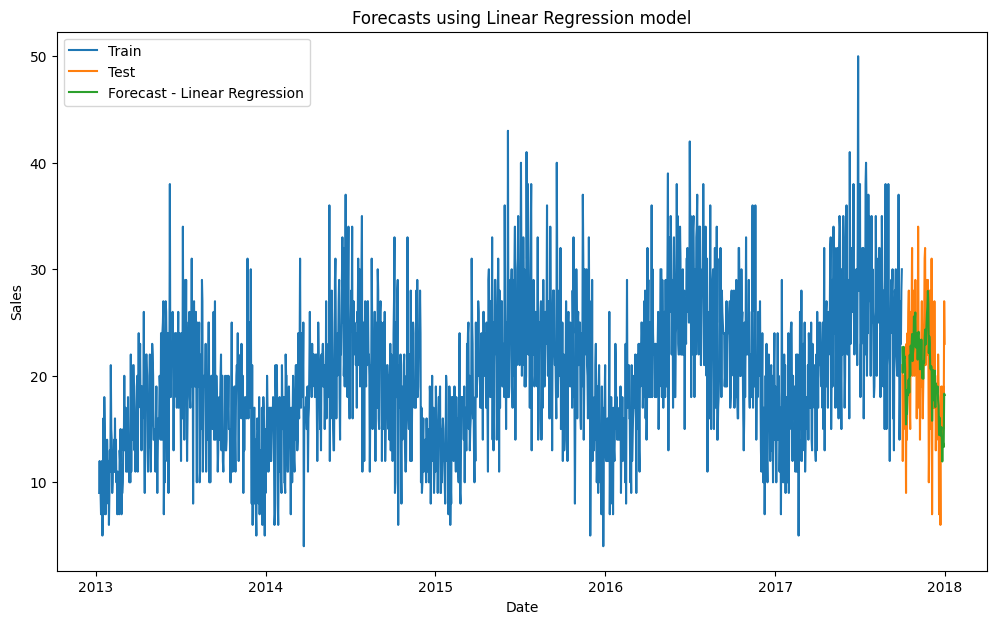

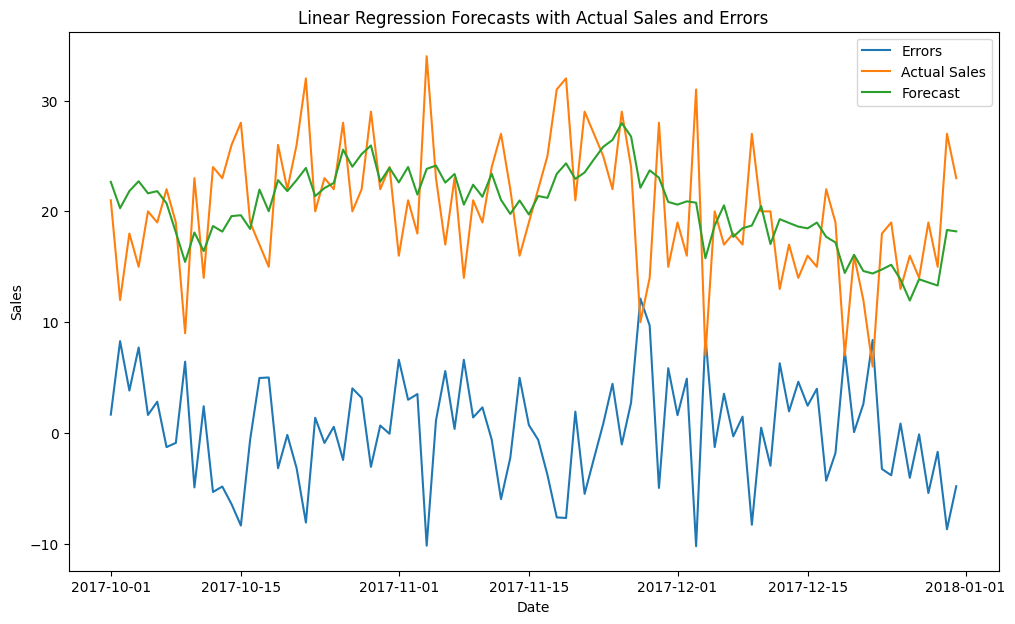

,total_sales,total_pred_sales,LR_overall_error,MAE,RMSE,MAPE
model,,,,,,
LinearRegression,1861,1882.074831,21.074831,3.858646,4.786183,19.075519


In [66]:
# Visualizing Forecasts vs Actual Sales
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
ax.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
ax.plot(errors_df.index, errors_df['pred_sales'], label='Forecast - Linear Regression')
ax.legend(loc='best')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Forecasts using Linear Regression model')
plt.show()

# Visualizing Linear Regression Forecasts with Actual Sales and Errors
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(errors_df.index, errors_df['errors'], label='Errors')
ax.plot(errors_df.index, errors_df['sales'], label='Actual Sales')
ax.plot(errors_df.index, errors_df['pred_sales'], label='Forecast')
ax.legend(loc='best')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Linear Regression Forecasts with Actual Sales and Errors')
plt.show()

# Calculating Metrics and Aggregating Results
result_df_lr = errors_df.groupby('model').agg(
    total_sales=('sales', 'sum'),
    total_pred_sales=('pred_sales', 'sum'),
    LR_overall_error=('errors', 'sum'),
    MAE=('errors', mae),
    RMSE=('errors', rmse),
    MAPE=('errors', mape)
)

result_df_lr